<a href="https://colab.research.google.com/github/andreafought/FINAL-PROJECT/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benford's Law and Image Tampering**

Table of Contents:  
1.   Prediction
2.   Import libraries
3.   Benford's Law
4.   Function to Transform Images to DCT and Collect First Number Digits
5. Import Image Dataset and Create Dataframe
6.   Application of machine learning (decision tree)


#**1. Prediction** -- Has your image been tampered ?

In [1]:
#Insert image
from google.colab import files
Image = files.upload()

Saving IMG1.jpeg to IMG1.jpeg


In [132]:
#Code to get frequency of first digit nunbers from DCT
data_freq = []
fct = compute_first_digits("IMG1.jpeg", normalise=True, debug_dct=False)
lat = fct.reshape(fct.shape[0]*fct.shape[1],).tolist()
freq = {} 
for item in lat: 
  if (item in freq): 
    freq[item] += 1
  else: 
    freq[item] = 1
data_freq.append(freq)
new = pd.DataFrame(data_freq)

In [133]:
#Switch columns 
new = new[[1,2,3,4,5,6,7,8,9]]

In [134]:
new

,1,2,3,4,5,6,7,8,9
0,3547241,2221281,1607570,1224551,973256,804896,685928,596351,531694


In [135]:
NewPredict = treemodel.predict(new)

In [136]:
#Answer question if image has been tampered: 0-No 1-YES
NewPredict

array([0], dtype=uint8)

#2. Import Libraries

In [85]:
from google.colab import files
import math
from PIL import Image
import numpy as np
import pandas as pd
import cv2 as cv2
from google.colab.patches import cv2_imshow    
from skimage import io
import glob
from tqdm import tqdm
from skimage import data, io, filters
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn import under_sampling, over_sampling 
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
import shutil
import os
from sklearn.model_selection import train_test_split

#3. Benford's Law

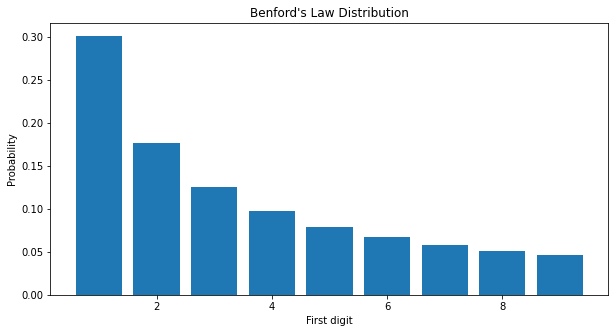

In [86]:
#Benford's Law histogram
x = np.arange(1, 10)
benford = np.log10(1 + 1 / x)
plt.figure(figsize=(10,5))
plt.bar(x, benford)
plt.title("Benford's Law Distribution")
plt.xlabel('First digit')
plt.ylabel('Probability')
plt.show()
plt.close()

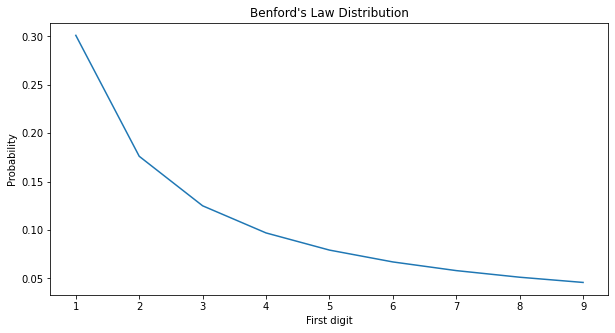

In [87]:
#Benford's Law with a linear histogram
plt.figure(figsize=(10,5))
plt.plot(x, benford)
plt.title("Benford's Law Distribution")
plt.xlabel('First digit')
plt.ylabel('Probability')
plt.show()
plt.close()

#4. Function to Transform Images to DCT and Collect First Number Digits

In [88]:
def compute_first_digits(img, normalise=False, debug_dct=False):
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        
    if len(img.shape) == 3 :
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if normalise:
        norm = cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
        

    dct = cv2.dct(np.float32(img) / 255.0)
    dct = np.abs(dct)  # Take abs values
    if debug_dct:
        print(dct)

    min_val = dct.min()
    if min_val < 1:
        dct = np.power(10, -np.floor(np.log10(min_val)) + 1) * dct  # Scale all up to remove leading 0.00s
    
    if not (dct >= 1.0).all():
        raise ValueError("Error")
    
    digits = np.log10(dct).astype(int).astype('float32')
    first_digits = dct / np.power(10, digits)
    first_digits[(first_digits < 1.0) & (first_digits > 0.9)] = 1  # Handle edge case.
    first_digits = first_digits.astype(int)
    
    if not (first_digits >= 1).all() and (first_digits <= 9).all():
        raise ValueError("Error")

    return first_digits


def compute_first_digits_counts(img, normalise=False):
    first_digits = compute_first_digits(img, normalise=normalise)
    unq, counts = np.unique(first_digits, return_counts=True)
    return unq, counts

# 5. Import Image Dataset and Create Dataframe

In [89]:
#Unmount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Authentic Images

In [90]:
#Import authentic images
!unzip gdrive/MyDrive/IMG_Project/Authentic.zip

Archive:  gdrive/MyDrive/IMG_Project/Authentic.zip
replace Authentic/CRW_4827_scale.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Authentic/CRW_4827_scale.jpg  
  inflating: __MACOSX/Authentic/._CRW_4827_scale.jpg  
  inflating: Authentic/DSC_0535_scale.jpg  
  inflating: __MACOSX/Authentic/._DSC_0535_scale.jpg  
  inflating: Authentic/DSC_1549_scale.jpg  
  inflating: __MACOSX/Authentic/._DSC_1549_scale.jpg  
  inflating: Authentic/DSC_1580_scale.jpg  
  inflating: __MACOSX/Authentic/._DSC_1580_scale.jpg  
  inflating: Authentic/DSCN2320_scale.jpg  
  inflating: __MACOSX/Authentic/._DSCN2320_scale.jpg  
  inflating: Authentic/CRW_4833_scale.jpg  
  inflating: __MACOSX/Authentic/._CRW_4833_scale.jpg  
  inflating: Authentic/DSCN48_scale.jpg  
  inflating: __MACOSX/Authentic/._DSCN48_scale.jpg  
  inflating: Authentic/DSCF1853_scale.jpg  
  inflating: __MACOSX/Authentic/._DSCF1853_scale.jpg  
  inflating: Authentic/sony_63_scale.jpg  
  inflating: __MACOSX/Authentic/._sony_6

In [91]:
#Create list of images
authentic_img = []
for root, subdirs, files in os.walk("."):
  for file in files:
     if file.endswith("jpg"):
         authentic_img.append(os.path.join(root, file))

In [92]:
#Create list of the Authentic images
authentic_img2 = [img.lstrip("./") for img in authentic_img if img.startswith("./Authentic")]

In [93]:
img_even = []
for root, subdirs, files in os.walk("./even_imgs"):
  for file in files:
     if file.endswith("jpg"):
         img_even.append(os.path.join(root, file))

In [94]:
#Function if image has even dimensions 
from PIL import Image
import os.path
def is_img_even(file_img):
  img = Image.open(file_img)
  size = img.size
  if size[0] % 2 == 0  and size[1] % 2 == 0:
  #print("Image is even", size)
    return True
  else:
  #print("Image is odd", size)
    return False

In [95]:
#Create folder with all even authentic images 
!mkdir even_imgs

mkdir: cannot create directory ‘even_imgs’: File exists


In [96]:
#Import even authentic images into new folder
import shutil
for img in authentic_img2:
  if is_img_even(img):
    shutil.copy(img, "./even_imgs/"+os.path.basename(img))

In [97]:
#Create authentic dataframe with image, and the frequency of first digits
c = 0
data_freq = []
for i in img_even:

  fct = compute_first_digits(i, normalise=True, debug_dct=False)
  com = fct.reshape(fct.shape[0]*fct.shape[1],).tolist()
  freq = {} 
  for item in com: 
    if (item in freq): 
      freq[item] += 1
    else: 
      freq[item] = 1
  freq['Img']= i
  data_freq.append(freq)
df = pd.DataFrame(data_freq)

In [98]:
df['Tampered?']= "No"

In [99]:
df

,3,2,4,1,6,8,9,7,5,Img,Tampered?
0,58764,83913,45482,146147,32332,24897,22381,28172,37912,./even_imgs/DSCF6_scale.jpg,No
1,59333,88017,44647,149993,30122,23837,22000,26656,35395,./even_imgs/sony_67_scale.jpg,No
2,51785,76100,39509,132818,27520,21575,19675,24231,32387,./even_imgs/DSC_1535_scale.jpg,No
3,59636,85509,45690,146103,31879,24110,21971,27639,37463,./even_imgs/P1000213_scale.jpg,No
4,59922,84316,46248,143747,32467,24698,22100,28172,38330,./even_imgs/DSCF4_scale.jpg,No
...,...,...,...,...,...,...,...,...,...,...,...
59,59897,82576,47810,141136,33246,25078,22065,28817,39375,./even_imgs/sony_61_scale.jpg,No
60,42959,60959,33135,106346,22767,17758,16007,19815,26814,./even_imgs/DSC_1538_scale.jpg,No
61,43647,59512,34759,101811,24032,17880,15929,20756,28234,./even_imgs/DSC_1570_scale.jpg,No
62,61313,86696,47110,142639,31829,23741,21493,27389,37790,./even_imgs/sony_66_scale.jpg,No


Tampered Images

In [100]:
#Import tampered images
!unzip gdrive/MyDrive/IMG_Project/Tampered.zip

Archive:  gdrive/MyDrive/IMG_Project/Tampered.zip
replace Tampered/DSCN45tamp176.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Tampered/DSCN45tamp176.jpg  
  inflating: __MACOSX/Tampered/._DSCN45tamp176.jpg  
  inflating: Tampered/DSC_1540tamp131.jpg  
  inflating: __MACOSX/Tampered/._DSC_1540tamp131.jpg  
  inflating: Tampered/DSC_1540tamp27.jpg  
  inflating: __MACOSX/Tampered/._DSC_1540tamp27.jpg  
  inflating: Tampered/CRW_4901_JFRtamp37.jpg  
  inflating: __MACOSX/Tampered/._CRW_4901_JFRtamp37.jpg  
  inflating: Tampered/DSCN41tamp27.jpg  
  inflating: __MACOSX/Tampered/._DSCN41tamp27.jpg  
  inflating: Tampered/sony_61tamp37.jpg  
  inflating: __MACOSX/Tampered/._sony_61tamp37.jpg  
  inflating: Tampered/DSC_0812tamp27.jpg  
  inflating: __MACOSX/Tampered/._DSC_0812tamp27.jpg  
  inflating: Tampered/CRW_4853tamp176.jpg  
  inflating: __MACOSX/Tampered/._CRW_4853tamp176.jpg  
  inflating: Tampered/DSCF8tamp131.jpg  
  inflating: __MACOSX/Tampered/._DSCF8tamp131.jpg  
 

In [101]:
#Create list of images
tampered_img = []
for root, subdirs, files in os.walk("."):
  for file in files:
     if file.endswith(".jpg"):
         tampered_img.append(os.path.join(root, file))

In [102]:
#Create list of the Tampered images
tampered_img2 = [img.lstrip("./") for img in tampered_img if img.startswith("./Tampered")]

In [103]:
#
img_even_tampered = []
for root, subdirs, files in os.walk("./even_imgs_tampered"):
  for file in files:
     if file.endswith("jpg"):
         img_even_tampered.append(os.path.join(root, file))

In [104]:
#Create folder with all even tampered images 
!mkdir even_imgs_tampered

mkdir: cannot create directory ‘even_imgs_tampered’: File exists


In [105]:
#Import even tampered images into
import shutil
for img in tampered_img2:
  if is_img_even(img):
    shutil.copy(img, "./even_imgs_tampered/"+os.path.basename(img))

In [106]:
#Create tampered dataframe with image, and the frequency of first digits
c = 0
data_freq = []
for i in img_even_tampered:

  fct = compute_first_digits(i, normalise=True, debug_dct=False)
  com = fct.reshape(fct.shape[0]*fct.shape[1],).tolist()
  freq = {} 
  for item in com: 
    if (item in freq): 
      freq[item] += 1
    else: 
      freq[item] = 1
  freq['Img']= i
  data_freq.append(freq)
df2 = pd.DataFrame(data_freq)

In [107]:
df2['Tampered?']= "Yes"

In [108]:
df2

,2,4,1,6,3,8,9,7,5,Img,Tampered?
0,67994,42312,124966,31393,50852,23702,20970,27297,36114,./even_imgs_tampered/DSC_0535tamp237.jpg,Yes
1,86566,48357,141136,31581,62598,23606,21104,26909,38143,./even_imgs_tampered/DSCF8tamp1.jpg,Yes
2,75188,42780,123953,28424,55256,21586,18991,24667,34755,./even_imgs_tampered/DSC_1568tamp37.jpg,Yes
3,77464,41299,128406,27372,54385,20991,18842,23958,32883,./even_imgs_tampered/DSC_1540tamp132.jpg,Yes
4,86741,48041,140802,31921,62649,23488,20825,27211,38322,./even_imgs_tampered/DSCF8tamp176.jpg,Yes
...,...,...,...,...,...,...,...,...,...,...,...
65,89862,48748,138212,31050,65003,22745,20393,25904,38083,./even_imgs_tampered/DSCF8tamp134.jpg,Yes
66,89256,49176,138023,31264,64550,22950,20324,25956,38501,./even_imgs_tampered/DSCF8tamp133.jpg,Yes
67,75333,42552,123843,28974,54824,21635,19190,24386,34863,./even_imgs_tampered/DSC_1568tamp237.jpg,Yes
68,87024,48114,140383,31432,63005,23606,20973,27069,38394,./even_imgs_tampered/DSCF8tamp131.jpg,Yes


In [109]:
#Combine authentic and tampered dataframe
final = pd.concat([df, df2])

In [110]:
#Create ID fro each image in dataframe
ids = []
for i in range(len(final)):
  ids.append("IMG"+str((i+1)))

final['ID'] = ids

In [111]:
#Reorganize columns
final = final[['ID','Img','Tampered?',1,2,3,4,5,6,7,8,9]]

In [112]:
final

,ID,Img,Tampered?,1,2,3,4,5,6,7,8,9
0,IMG1,./even_imgs/DSCF6_scale.jpg,No,146147,83913,58764,45482,37912,32332,28172,24897,22381
1,IMG2,./even_imgs/sony_67_scale.jpg,No,149993,88017,59333,44647,35395,30122,26656,23837,22000
2,IMG3,./even_imgs/DSC_1535_scale.jpg,No,132818,76100,51785,39509,32387,27520,24231,21575,19675
3,IMG4,./even_imgs/P1000213_scale.jpg,No,146103,85509,59636,45690,37463,31879,27639,24110,21971
4,IMG5,./even_imgs/DSCF4_scale.jpg,No,143747,84316,59922,46248,38330,32467,28172,24698,22100
...,...,...,...,...,...,...,...,...,...,...,...,...
65,IMG130,./even_imgs_tampered/DSCF8tamp134.jpg,Yes,138212,89862,65003,48748,38083,31050,25904,22745,20393
66,IMG131,./even_imgs_tampered/DSCF8tamp133.jpg,Yes,138023,89256,64550,49176,38501,31264,25956,22950,20324
67,IMG132,./even_imgs_tampered/DSC_1568tamp237.jpg,Yes,123843,75333,54824,42552,34863,28974,24386,21635,19190
68,IMG133,./even_imgs_tampered/DSCF8tamp131.jpg,Yes,140383,87024,63005,48114,38394,31432,27069,23606,20973


#6. Application of Machine Learning using the Decision Tree Method

In [113]:
final.head(10)

,ID,Img,Tampered?,1,2,3,4,5,6,7,8,9
0,IMG1,./even_imgs/DSCF6_scale.jpg,No,146147,83913,58764,45482,37912,32332,28172,24897,22381
1,IMG2,./even_imgs/sony_67_scale.jpg,No,149993,88017,59333,44647,35395,30122,26656,23837,22000
2,IMG3,./even_imgs/DSC_1535_scale.jpg,No,132818,76100,51785,39509,32387,27520,24231,21575,19675
3,IMG4,./even_imgs/P1000213_scale.jpg,No,146103,85509,59636,45690,37463,31879,27639,24110,21971
4,IMG5,./even_imgs/DSCF4_scale.jpg,No,143747,84316,59922,46248,38330,32467,28172,24698,22100
5,IMG6,./even_imgs/DSCF7_scale.jpg,No,146856,83192,58544,45796,37987,32235,28026,24972,22392
6,IMG7,./even_imgs/DSC_1573_scale.jpg,No,98740,54957,42641,35971,29941,26024,22370,19107,16809
7,IMG8,./even_imgs/sony_70_scale.jpg,No,144194,87158,61402,46726,37466,31356,26900,23805,20993
8,IMG9,./even_imgs/DSCF2_scale.jpg,No,145485,85037,59424,46144,37471,31717,28023,24748,21951
9,IMG10,./even_imgs/DSC_1550_scale.jpg,No,104692,61369,43434,33171,27493,22953,20038,17722,15688


In [114]:
from google.colab import files

final.to_csv('img_df.csv')
files.download('img_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 69
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         134 non-null    object
 1   Img        134 non-null    object
 2   Tampered?  134 non-null    object
 3   1          134 non-null    int64 
 4   2          134 non-null    int64 
 5   3          134 non-null    int64 
 6   4          134 non-null    int64 
 7   5          134 non-null    int64 
 8   6          134 non-null    int64 
 9   7          134 non-null    int64 
 10  8          134 non-null    int64 
 11  9          134 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 13.6+ KB


In [116]:
#Count how many images of each - Do i need SMOTE?
final['Tampered?'].value_counts()

Yes    70
No     64
Name: Tampered?, dtype: int64

In [117]:
#Drop ID, and Img from dataframe
final_drop = final.drop(columns=['ID', 'Img']) 

In [60]:
#Split numerical and categorical data into two dataframes
data_num=final_drop.drop(columns=['Tampered?'])
data_cat=final_drop.drop(columns=[1,2,3,4,5,6,7,8,9])

In [61]:
#Get dummies for Tampered? column
y_cat=pd.get_dummies(data_cat, drop_first=True)

In [62]:
df = pd.concat((data_num, y_cat),axis=1)

In [63]:
df

,1,2,3,4,5,6,7,8,9,Tampered?_Yes
0,146147,83913,58764,45482,37912,32332,28172,24897,22381,0
1,149993,88017,59333,44647,35395,30122,26656,23837,22000,0
2,132818,76100,51785,39509,32387,27520,24231,21575,19675,0
3,146103,85509,59636,45690,37463,31879,27639,24110,21971,0
4,143747,84316,59922,46248,38330,32467,28172,24698,22100,0
...,...,...,...,...,...,...,...,...,...,...
65,138212,89862,65003,48748,38083,31050,25904,22745,20393,1
66,138023,89256,64550,49176,38501,31264,25956,22950,20324,1
67,123843,75333,54824,42552,34863,28974,24386,21635,19190,1
68,140383,87024,63005,48114,38394,31432,27069,23606,20973,1


In [64]:
#Define X
X=df.drop(columns=['Tampered?_Yes'])

In [65]:
#Define target y 
y=df['Tampered?_Yes']

In [66]:
tree = DecisionTreeClassifier()

In [67]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=40)

In [68]:
treemodel=tree.fit(X_train,y_train)

In [69]:
y_pred = treemodel.predict(X_test)

In [70]:
accuracy_score(y_test, y_pred)

0.7317073170731707

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.61      0.67        18
           1       0.73      0.83      0.78        23

    accuracy                           0.73        41
   macro avg       0.73      0.72      0.72        41
weighted avg       0.73      0.73      0.73        41



In [72]:
cnf_matrix = confusion_matrix(y_test,y_pred)

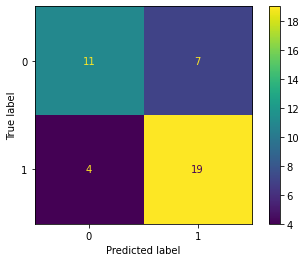

In [73]:
plot_confusion_matrix(tree,X_test, y_test)

In [74]:
#ROC
probs = tree.predict_proba(X_test)
preds =probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.7185990338164252


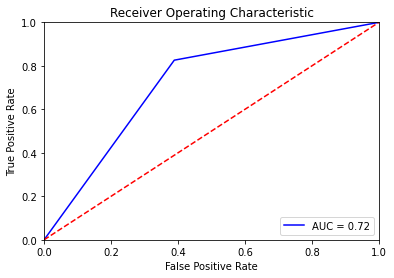

In [75]:
#Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()